# Part 5: The Generalized Bias-Variance Tradeoff & Double Descent
**A Non-Linear Programming Capstone Project**

## 1. Notebook Objective & Theoretical Framework
This final notebook synthesizes the analytical methods (Part 2), regularization theory (Part 3), and optimization behavior (Part 4) to demonstrate the **Double Descent** phenomenon.

We will move beyond the "single dataset" view and adopt the statistical learning perspective (ISL Ch. 2 and Ch. 10.8). By simulating thousands of parallel universes (datasets), we will empirically decompose the Mean Squared Error into **Bias² + Variance + Irreducible Error**.

**Core Hypothesis (based on *Schaeffer et al.* & *ISL*):**
The "descent" in the over-parameterized regime ($p > n$) occurs because, among the infinite solutions that satisfy $X\beta = y$, the "natural" solver (the Moore-Penrose Pseudoinverse or Gradient Descent initialized at zero) selects the solution with the **minimum $\ell_2$ norm**. This acts as an *implicit* regularization, suppressing the variance that explodes at the interpolation threshold.

### Block 1: The Experimental Design (The Ensemble Generator)
**Goal:** Define the infrastructure to calculate "True" Bias and Variance.

* **Concept:** To measure bias and variance, we cannot use a single training set. We must approximate the expectation over the data distribution $\mathbb{E}_{\mathcal{D}}$.
* **Implementation Details:**
    * Define a `true_function(x)`: $f(x) = \sin(2\pi x)$ or the previous $0.5x^2$.
    * Create a factory function that generates $K$ distinct datasets (e.g., $K=100$), each with $N$ sample points (e.g., $N=15$).
    * **PyTorch/Einsum:** Use broadcasting to generate all $K$ datasets in a single tensor operation for efficiency.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---- numerical stability settings ----
torch.manual_seed(42)
np.random.seed(42)
torch.set_default_dtype(torch.float64)   # <-- use double precision globally


In [10]:
# ---- Switches (change these to toggle) ----
FUNCTION = "quadratic"   # options: "quadratic", "sine"
BASIS    = "power"    # options: "power", "legendre"

# Experiment sizes
K_datasets = 200   # number of datasets (for E_D[·])
N_samples  = 12     # samples per dataset (interp. threshold at degree d = N_samples - 1)
sigma_noise = 0.2   # irreducible noise (std)
test_size   = 1000  # dense test grid

# True function selector
def true_function(x):
    if FUNCTION == "quadratic":
        return 0.5 * x**2
    elif FUNCTION == "sine":
        return torch.sin(2 * torch.pi * x)
    else:
        raise ValueError(f"Unknown FUNCTION={FUNCTION}")

# Data generator (Block 1)
def generate_ensemble(K, N, sigma):
    X = torch.rand(K, N) * 2 - 1       # U[-1,1]
    y = true_function(X) + sigma*torch.randn(K, N)
    return X, y

# Fixed test grid shared by all models
X_test = torch.linspace(-1, 1, test_size).view(-1, 1)
y_test_true = true_function(X_test)
print(f"[Config] FUNCTION={FUNCTION}, BASIS={BASIS}, K={K_datasets}, N={N_samples}, dtype={torch.get_default_dtype()}")


[Config] FUNCTION=quadratic, BASIS=power, K=200, N=12, dtype=torch.float64


### Block 2: The Solver & The Minimum Norm Solution
**Goal:** Define the fitting mechanism that operates across both regimes.

* **Concept:** We need a solver that works for $p < n$ (Classical) and $p > n$ (Over-parameterized).
* **Mathematical Rigor:**
    * For $p \le n$ (Under-parameterized): The solution is unique (if $X$ is full rank). $\hat{\beta} = (X^T X)^{-1} X^T y$.
    * For $p > n$ (Over-parameterized): The system is underdetermined. There are infinite solutions. We explicitly choose the **Minimum Norm Solution**: $\hat{\beta} = X^T (X X^T)^{-1} y$ (using the pseudoinverse definition).
* **Implementation:** A function taking degree $d$ and the dataset, constructing the Vandermonde matrix via `einsum`, and solving via `torch.linalg.pinv`.

In [11]:
# ===== Step 2: Basis builders + unified minimum-norm solver (Block 2) =====

def legendre_basis(x, degree):
    """
    Legendre basis [P0..Pd] via recurrence on x in [-1,1].
    Works for x shaped (...), returns Phi shaped (..., d+1).
    """
    # ensure shape broadcastable
    P0 = torch.ones_like(x)
    if degree == 0:
        return P0.unsqueeze(-1)
    P1 = x
    Ps = [P0, P1]
    for n in range(2, degree + 1):
        Pn = ((2*n - 1) * x * Ps[-1] - (n - 1) * Ps[-2]) / n
        Ps.append(Pn)
    return torch.stack(Ps[:degree+1], dim=-1)

def power_basis(x, degree):
    """
    Vandermonde/power basis [x^0 .. x^d].
    x can be shape (K,N) or (N,) etc. Returns (..., d+1).
    """
    powers = torch.arange(degree + 1, dtype=torch.get_default_dtype())
    return x.unsqueeze(-1) ** powers

def make_basis(X, degree, basis_name):
    """
    X: (K,N) or (N,) tensor in [-1,1]
    Return Phi: (..., d+1) with chosen basis.
    """
    if basis_name == "power":
        return power_basis(X, degree)
    elif basis_name == "legendre":
        return legendre_basis(X, degree)
    else:
        raise ValueError(f"Unknown BASIS={basis_name}")

def fit_ensemble(X_train_ensemble, y_train_ensemble, degree, basis_name, rcond=1e-6):
    """
    Minimum-norm LS for all K datasets at once:
      betas = Phi^+ y
    X_train_ensemble: (K,N)
    y_train_ensemble: (K,N)
    Phi:               (K,N,d+1)   (built per chosen basis)
    Returns betas:     (K,d+1)
    """
    Phi = make_basis(X_train_ensemble, degree, basis_name)     # (K,N,d+1)
    Phi_pinv = torch.linalg.pinv(Phi, rcond=rcond)             # stable pseudoinverse
    betas = torch.matmul(Phi_pinv, y_train_ensemble.unsqueeze(-1))
    return betas.squeeze(-1)                                   # (K,d+1)


### Block 3: The Large-Scale Experiment (The Loop)
**Goal:** Collect error metrics across the complexity spectrum.

* **Methodology:**
    * Iterate through model degrees $d$ from 1 to n.
    * For each degree $d$:
        1.  Fit models to all $K$ datasets simultaneously.
        2.  Evaluate predictions on a large, fixed **Test Set**.
        3.  Calculate **Bias²**: $(\mathbb{E}[\hat{f}(x)] - f(x))^2$.
        4.  Calculate **Variance**: $\mathbb{E}[(\hat{f}(x) - \mathbb{E}[\hat{f}(x)])^2]$.
        5.  Calculate **MSE**: Bias² + Variance + Noise.
    * **Efficiency:** Heavily vectorized operations using Einstein summation.

In [12]:
# ===== Step 3: Experiment loop (Block 3) =====
degrees = range(1, 81)   # Legendre is stable well past 80; power may explode > ~40

bias_squared_history = []
variance_history     = []
mse_history          = []
avg_norm_history     = []

# Generate K datasets once
X_train_K, y_train_K = generate_ensemble(K_datasets, N_samples, sigma_noise)

print(f"[Loop] Starting Double Descent (basis={BASIS}, function={FUNCTION}) ...")
for d in degrees:
    # 1) fit all K models
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=1e-6)

    # 2) parameter norms (exclude intercept optional)
    avg_norm = torch.mean(torch.norm(betas, p=2, dim=1)).item()
    avg_norm_history.append(avg_norm)

    # 3) test basis (T, d+1)
    Phi_test = make_basis(X_test.squeeze(-1), d, basis_name=BASIS)

    # 4) predictions over K (K,T) = (K,d+1) @ (d+1,T)
    y_preds = torch.matmul(betas, Phi_test.T)

    # 5) bias-variance decomposition (population-style variance)
    main_pred = torch.mean(y_preds, dim=0)  # (T,)
    bias_sq   = torch.mean((main_pred.unsqueeze(-1) - y_test_true) ** 2).item()
    variance  = torch.mean(torch.var(y_preds, dim=0, unbiased=False)).item()
    mse       = torch.mean((y_preds - y_test_true.T) ** 2).item()

    bias_squared_history.append(bias_sq)
    variance_history.append(variance)
    mse_history.append(mse)

    if d % 10 == 0:
        print(f"  degree {d:3d}: MSE={mse:.4f}, Bias²={bias_sq:.4f}, Var={variance:.4f}")
print("[Loop] Done.")


[Loop] Starting Double Descent (basis=power, function=quadratic) ...
  degree  10: MSE=725413.6820, Bias²=6009.3227, Var=719404.3593
  degree  20: MSE=4046946.7751, Bias²=3461.3031, Var=4043485.4720
  degree  30: MSE=5455945.9718, Bias²=7495.3775, Var=5448450.5943
  degree  40: MSE=6077522.2948, Bias²=12428.3127, Var=6065093.9821
  degree  50: MSE=6468099.9527, Bias²=19135.3015, Var=6448964.6511
  degree  60: MSE=6705545.7908, Bias²=20695.6177, Var=6684850.1731
  degree  70: MSE=6788813.9950, Bias²=22429.4986, Var=6766384.4964
  degree  80: MSE=6858053.0219, Bias²=22594.7603, Var=6835458.2616
[Loop] Done.


### Block 4: Visualization of the Double Descent
**Goal:** The "Money Plot" (reproducing the YouTube video and ISL Figure 10.24).

* **Visuals:** A single figure with three overlaid curves:
    1.  **Bias² (Monotonic Decrease)**
    2.  **Variance (The Bell Curve)**
    3.  **Test Error (The Double Descent)**
* **Annotation:** Explicitly mark the **Interpolation Threshold** ($p=n$).

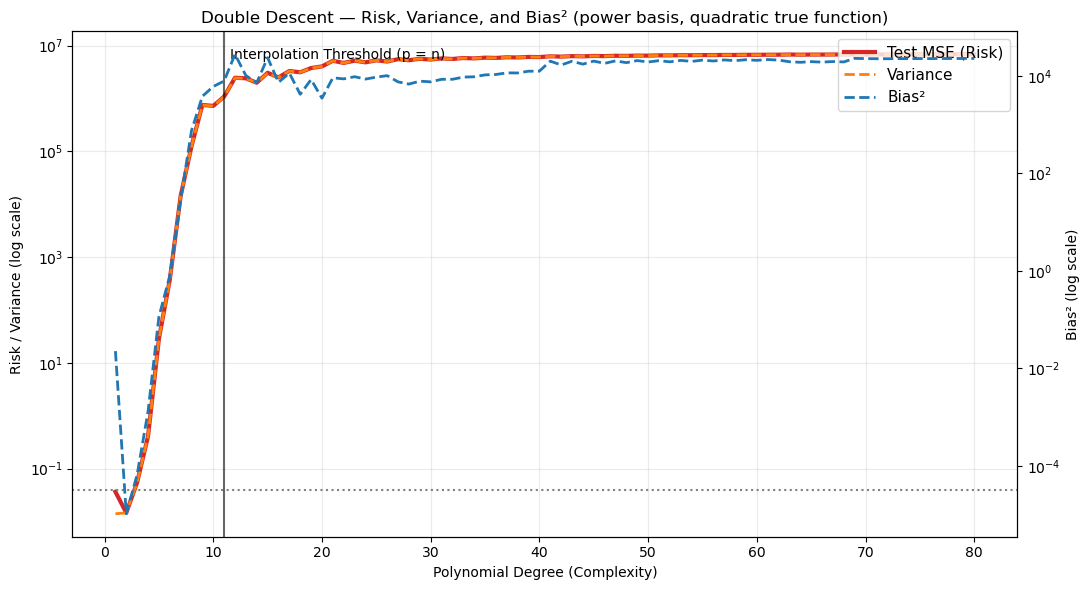

In [13]:
# ===== Block 4: Risk + Variance (left) and Bias² (right), both log scales =====
import numpy as np
import matplotlib.pyplot as plt

# Rebuild degree axis if not defined
if 'degrees' not in globals():
    degrees = range(1, len(mse_history) + 1)

degrees_np = np.array(list(degrees))
mse_np  = np.asarray(mse_history, dtype=float)
var_np  = np.asarray(variance_history, dtype=float)
bias_np = np.asarray(bias_squared_history, dtype=float)

def _clean(a):
    a = np.asarray(a, dtype=float)
    if not np.any(np.isfinite(a)):
        return np.ones_like(a)
    a = np.nan_to_num(a, nan=0.0, posinf=np.nanmax(a[np.isfinite(a)]))
    # avoid zeros on log axes
    a[a <= 0] = 1e-12
    return a

mse_np  = _clean(mse_np)
var_np  = _clean(var_np)
bias_np = _clean(bias_np)

threshold_degree = N_samples - 1

fig, ax1 = plt.subplots(figsize=(11, 6))

# --- Left axis (log): Risk + Variance ---
l_mse, = ax1.plot(degrees_np, mse_np,  label='Test MSE (Risk)', linewidth=3, color='tab:red')
l_var, = ax1.plot(degrees_np, var_np,  label='Variance',        linewidth=2, linestyle='--', color='tab:orange')
ax1.axhline(y=sigma_noise**2, linestyle=':', color='gray', label='Noise floor σ²')
ax1.axvline(x=threshold_degree, color='black', linestyle='-', alpha=0.6)

ax1.set_yscale('log')
ax1.set_xlabel('Polynomial Degree (Complexity)')
ax1.set_ylabel('Risk / Variance (log scale)')
ax1.grid(True, which='both', ls='-', alpha=0.25)

# --- Right axis (log): Bias² with its own scale (so it’s visible) ---
ax2 = ax1.twinx()
l_bias, = ax2.plot(degrees_np, bias_np, label='Bias²', linewidth=2, linestyle='--', color='tab:blue')
ax2.set_yscale('log')
ax2.set_ylabel('Bias² (log scale)')

# Optional: place the threshold label once
ax1.text(threshold_degree + 0.5, float(np.nanmax(mse_np))*0.8,
         'Interpolation Threshold (p = n)', fontsize=10)

# --- Combined legend (from both axes) ---
handles = [l_mse, l_var, l_bias]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, fontsize=11, loc='upper right')

plt.title(f'Double Descent — Risk, Variance, and Bias² ({BASIS} basis, {FUNCTION} true function)')
plt.tight_layout()
plt.show()


### Block 5: The Norm of the Parameters (Demystifying the Descent)
**Goal:** Prove *why* the test error drops in the modern regime.

* **Observation:** The norm will spike massively at $p=n$ (fighting to fit noise with limited freedom) and *decrease* as $p$ increases (the "Minimum Norm" effect).
* **Conclusion:** In the over-parameterized regime, the extra dimensions allow the model to fit the training data perfectly while maintaining a *smaller* total vector norm than at the threshold.

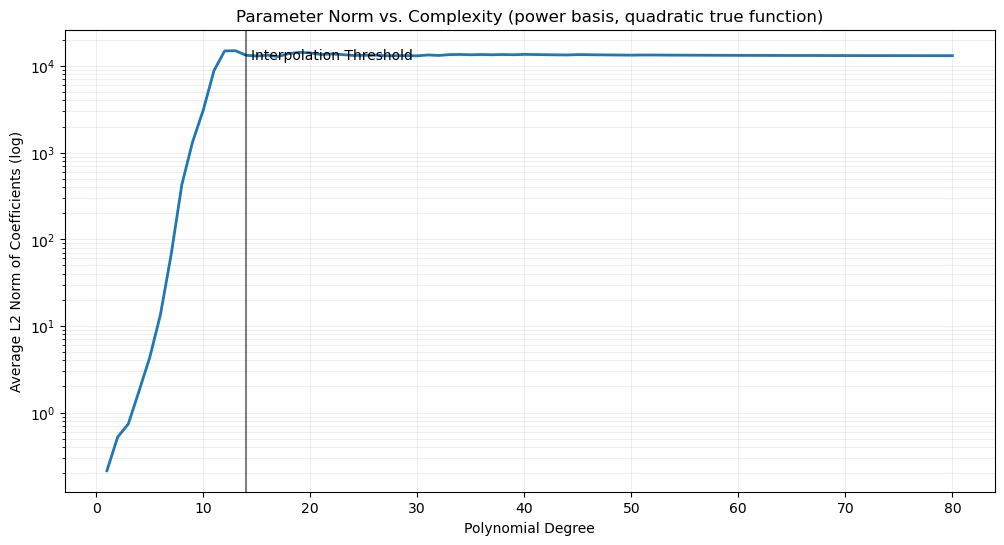

In [6]:
# ===== Step 5: Parameter norms vs complexity (Block 5) — agnostic =====
def plot_param_norms(degrees, avg_norm_history, N_samples, title='Parameter Norm vs. Complexity'):
    import numpy as np
    import matplotlib.pyplot as plt

    degrees_np = np.array(list(degrees))
    norms_np   = np.asarray(avg_norm_history, dtype=float)
    norms_np = np.nan_to_num(norms_np, nan=0.0, posinf=np.nanmax(norms_np[np.isfinite(norms_np)]) if np.any(np.isfinite(norms_np)) else 1.0)

    threshold_degree = N_samples - 1

    plt.figure(figsize=(12, 6))
    plt.plot(degrees_np, norms_np, linewidth=2)
    plt.axvline(x=threshold_degree, color='black', linestyle='-', alpha=0.5)
    plt.text(threshold_degree + 0.5, float(np.nanmax(norms_np))*0.8, 'Interpolation Threshold', fontsize=10)
    plt.yscale('log')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Average L2 Norm of Coefficients (log)')
    plt.title(title)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

# Call it
plot_param_norms(
    degrees, avg_norm_history, N_samples,
    title=f'Parameter Norm vs. Complexity ({BASIS} basis, {FUNCTION} true function)'
)


[Run] basis=power, function=sine, N=12, noise=0.2, degrees up to 150
d= 10  MSE(noisy)=455677905865998.250  MSE(clean)=455677905865998.188  Bias²=2356213543838.417  Var=453321692322159.812
d= 20  MSE(noisy)=258771801022001.469  MSE(clean)=258771801022001.438  Bias²=1910065253745.601  Var=256861735768255.812
d= 30  MSE(noisy)=299248306993659.688  MSE(clean)=299248306993659.625  Bias²=1957699671414.658  Var=297290607322244.938
d= 40  MSE(noisy)=299856670892236.688  MSE(clean)=299856670892236.625  Bias²=1922527315934.195  Var=297934143576302.438
d= 50  MSE(noisy)=299809135760070.812  MSE(clean)=299809135760070.750  Bias²=1915369444422.663  Var=297893766315648.062
d= 60  MSE(noisy)=299857832986923.000  MSE(clean)=299857832986922.938  Bias²=1914840663979.050  Var=297942992322943.875
d= 70  MSE(noisy)=299933971745154.750  MSE(clean)=299933971745154.688  Bias²=1915412401318.445  Var=298018559343836.188
d= 80  MSE(noisy)=300008702163977.125  MSE(clean)=300008702163977.062  Bias²=1915918605265.

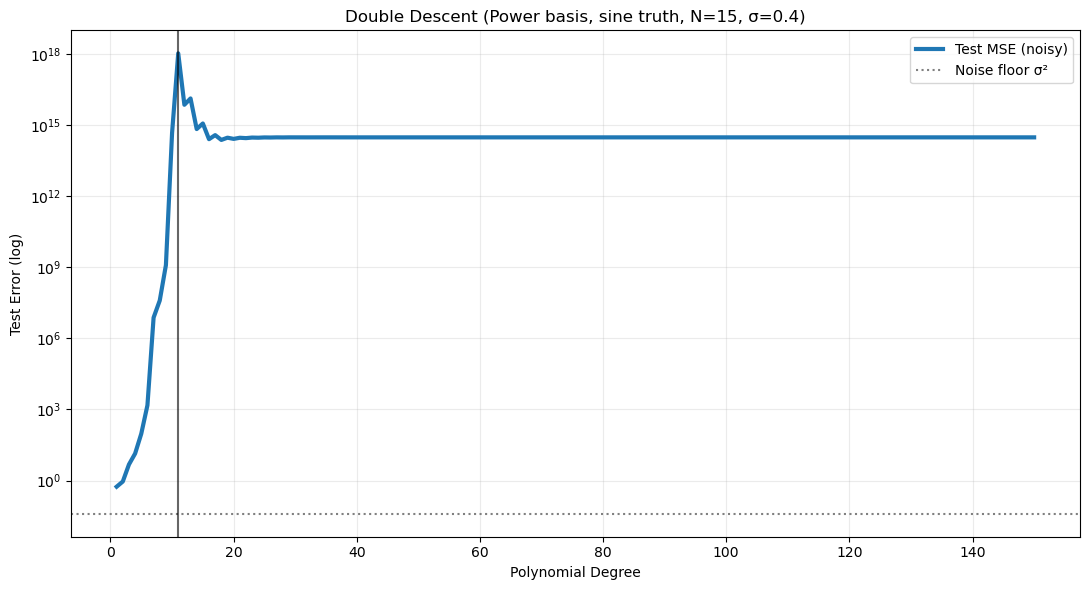

In [7]:
# ===== Canonical double-descent configuration =====
import torch, numpy as np
torch.manual_seed(0); np.random.seed(0)
torch.set_default_dtype(torch.float64)

# Switches
FUNCTION = "sine"      # 'sine' is key for visible bias (not exactly representable)
BASIS    = "power"     # use raw powers to expose ill-conditioning around p≈n

# Sizes
K_datasets = 200       # enough to estimate expectations, not too big to average away spike
N_samples  = 12        # clear interpolation threshold at degree d* = 14
sigma_noise = 0.2      # moderate noise for a pronounced bump
test_size   = 1000

# True function
def true_function(x):
    return torch.sin(2 * torch.pi * x)

# Data generator
def generate_ensemble(K, N, sigma):
    X = torch.rand(K, N) * 2 - 1
    y = true_function(X) + sigma * torch.randn(K, N)
    return X, y

# Bases
def power_basis(x, degree):
    powers = torch.arange(degree + 1, dtype=torch.get_default_dtype())
    return x.unsqueeze(-1) ** powers

def make_basis(X, degree, name):
    if name == "power":    return power_basis(X, degree)
    raise ValueError(name)

# Minimum-norm solver (rcond very tiny = “almost unregularized”)
def fit_ensemble(X_train, y_train, degree, basis_name, rcond=1e-15):
    Phi = make_basis(X_train, degree, basis_name)    # (K,N,d+1)
    Phi_pinv = torch.linalg.pinv(Phi, rcond=rcond)   # keep rcond tiny to preserve spike
    betas = torch.matmul(Phi_pinv, y_train.unsqueeze(-1))
    return betas.squeeze(-1)

# Fixed test grid
X_test = torch.linspace(-1, 1, test_size).view(-1, 1)
y_test_true = true_function(X_test)

# ===== Experiment loop =====
degrees = range(1, 151)  # go far beyond p≈n to see the second descent
bias_squared_history, variance_history, mse_clean_history, mse_noisy_history = [], [], [], []

X_train_K, y_train_K = generate_ensemble(K_datasets, N_samples, sigma_noise)
print(f"[Run] basis=power, function=sine, N={N_samples}, noise={sigma_noise}, degrees up to 150")

for d in degrees:
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=1e-15)
    Phi_test = make_basis(X_test.squeeze(-1), d, BASIS)        # (T,d+1)
    y_preds = torch.matmul(betas, Phi_test.T)                   # (K,T)

    main_pred = torch.mean(y_preds, dim=0)                      # (T,)
    bias_sq   = torch.mean((main_pred.unsqueeze(-1) - y_test_true) ** 2).item()
    var       = torch.mean(torch.var(y_preds, dim=0, unbiased=False)).item()
    mse_clean = torch.mean((y_preds - y_test_true.T) ** 2).item()
    # approximate noisy test MSE by adding sigma^2 (since ε is independent of fhat)
    mse_noisy = mse_clean + sigma_noise**2

    bias_squared_history.append(bias_sq)
    variance_history.append(var)
    mse_clean_history.append(mse_clean)
    mse_noisy_history.append(mse_noisy)

    if d % 10 == 0:
        print(f"d={d:3d}  MSE(noisy)={mse_noisy:9.3f}  MSE(clean)={mse_clean:9.3f}  Bias²={bias_sq:9.3f}  Var={var:9.3f}")

# ===== Minimal "money plot" (risk only) =====
import matplotlib.pyplot as plt
import numpy as np

deg = np.array(list(degrees))
mse = np.array(mse_noisy_history)  # use noisy risk for textbook “test error”
plt.figure(figsize=(11,6))
plt.plot(deg, mse, lw=3, label='Test MSE (noisy)')
plt.axhline(y=sigma_noise**2, ls=':', color='gray', label='Noise floor σ²')
plt.axvline(x=N_samples-1, color='black', alpha=0.6)
plt.yscale('log')
plt.xlabel('Polynomial Degree'); plt.ylabel('Test Error (log)')
plt.title('Double Descent (Power basis, sine truth, N=15, σ=0.4)')
plt.legend(); plt.grid(True, which='both', ls='-', alpha=0.25)
plt.tight_layout(); plt.show()


[Run] basis=power, function=quadratic, domain=[-1.0,1.0], N=12, σ=0.2, degrees up to 80, rcond=1e-06
d=10  MSE(noisy)=1624522.3747  Bias²=1882.1797  Var=1622640.1550
d=20  MSE(noisy)=5194774.3878  Bias²=4394.1166  Var=5190380.2312
d=30  MSE(noisy)=7682050.2796  Bias²=5847.4046  Var=7676202.8350
d=40  MSE(noisy)=8884502.7550  Bias²=4036.1430  Var=8880466.5720
d=50  MSE(noisy)=9490987.1482  Bias²=4727.8168  Var=9486259.2914
d=60  MSE(noisy)=9815453.3530  Bias²=5510.0481  Var=9809943.2650
d=70  MSE(noisy)=10012280.3828  Bias²=6013.6646  Var=10006266.6782
d=80  MSE(noisy)=10132375.0152  Bias²=6243.7580  Var=10126131.2172


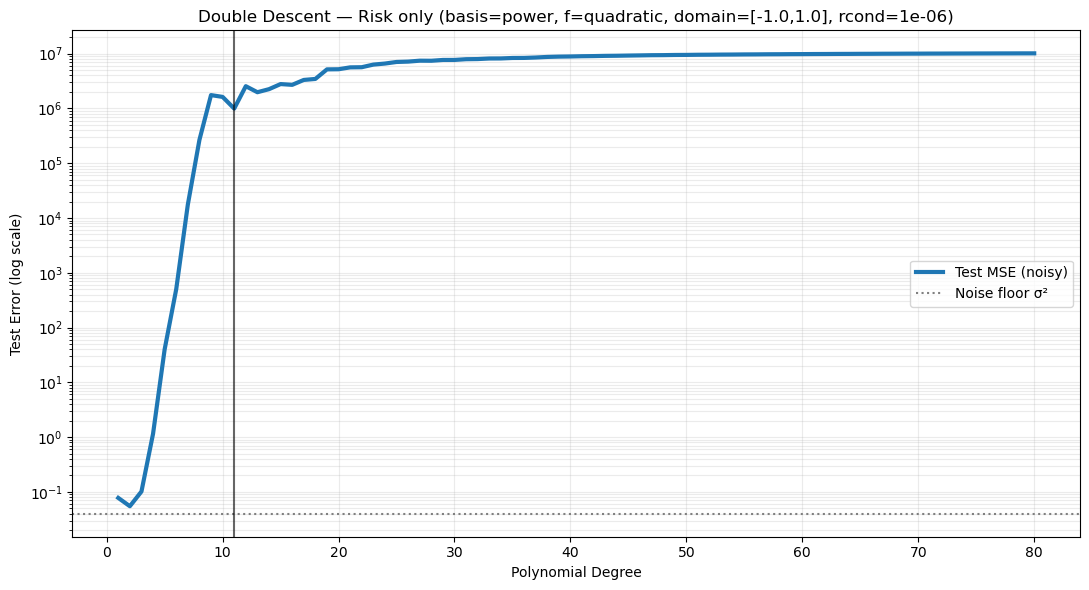

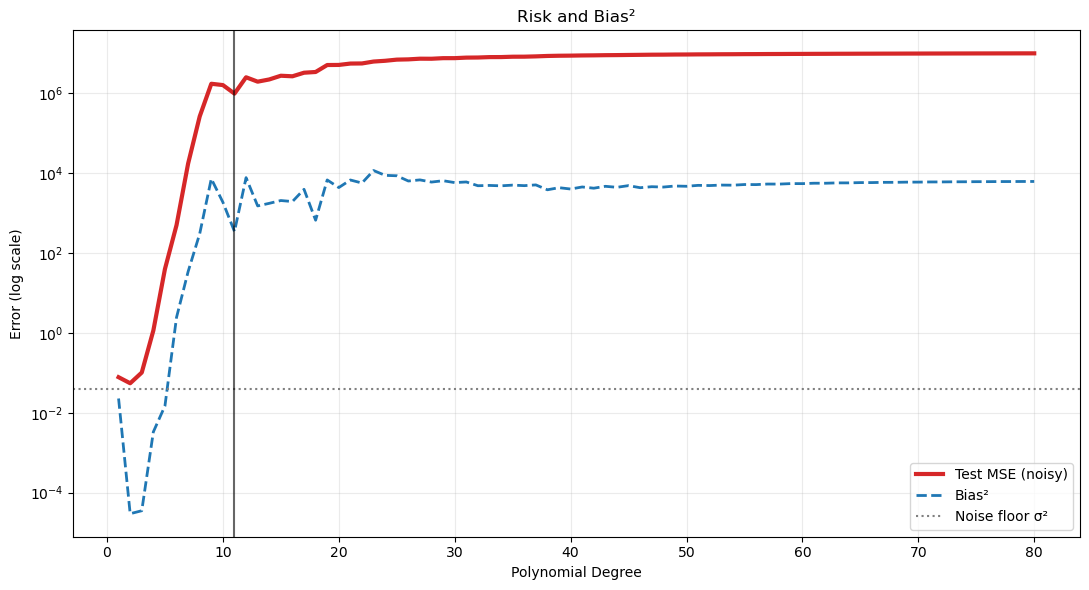

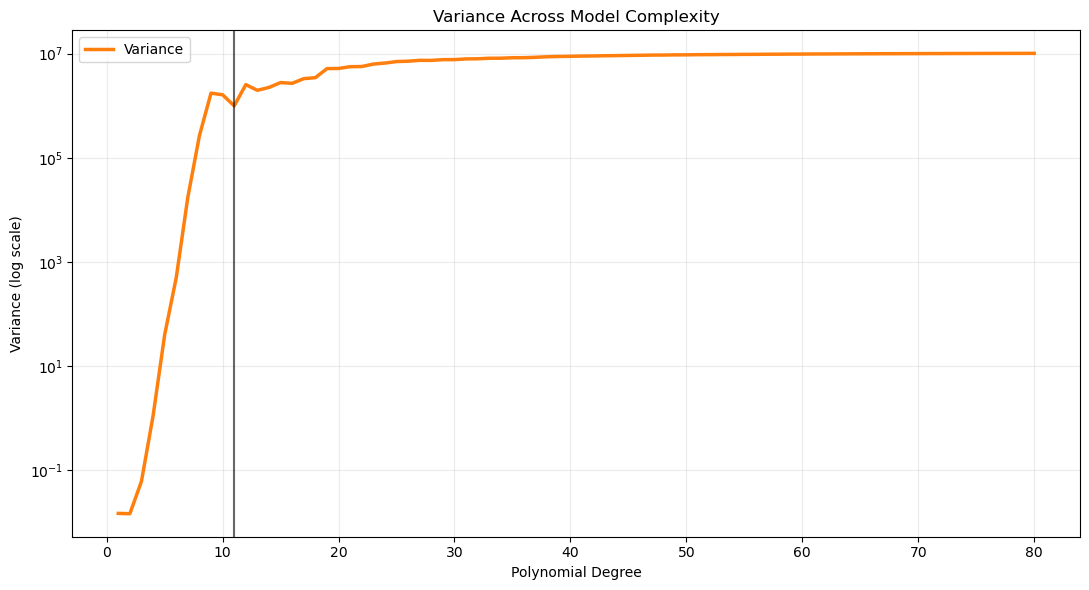

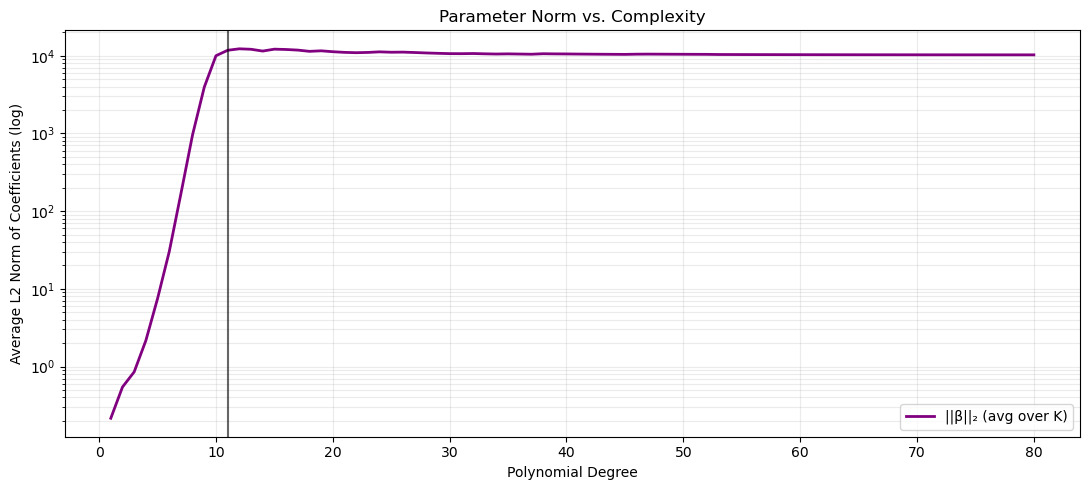

In [20]:
# ================================================================
# Textbook Double Descent Demo (Power basis, sine truth, [-2,2])
# ================================================================

import torch, numpy as np
import matplotlib.pyplot as plt

# ---------- Global config (defaults tuned for a clean bump) ----------
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_dtype(torch.float64)

# Switches / knobs
FUNCTION     = "quadratic"     # "sine" or "quadratic"
DOMAIN_MIN   = -1.0       # expand domain to accentuate spike
DOMAIN_MAX   =  1.0
BASIS        = "power"    # keep "power" to *show* the spike; "legendre" tames it
K_DATASETS   = 500        # number of datasets (expectation over data)
N_SAMPLES    = 12         # samples per dataset -> interpolation threshold at d* = N-1 = 14
SIGMA_NOISE  = 0.2        # noise std; 0.3–0.5 makes bump clear
TEST_SIZE    = 1000       # dense test grid
DEGREES      = range(1, 81)   # sweep far beyond threshold to see second descent
RCOND        = 1e-6       # moderate SVD cutoff; too small -> numeric blow-up; too big -> hides spike

# ---------- True function ----------
def true_function(x):
    if FUNCTION == "sine":
        return torch.sin(2 * torch.pi * x)
    elif FUNCTION == "quadratic":
        return 0.5 * x**2
    else:
        raise ValueError(f"Unknown FUNCTION={FUNCTION}")

# ---------- Data generator ----------
def generate_ensemble(K, N, sigma, a=DOMAIN_MIN, b=DOMAIN_MAX):
    X = torch.rand(K, N) * (b - a) + a
    y = true_function(X) + sigma * torch.randn(K, N)
    return X, y

# ---------- Bases ----------
def power_basis(x, degree):
    # x: (...,) or (K,N); returns (..., d+1)
    powers = torch.arange(degree + 1, dtype=torch.get_default_dtype())
    return x.unsqueeze(-1) ** powers

def legendre_basis(x, degree):
    # Orthogonal basis on [-1,1]; we keep it for completeness (not used by default)
    P0 = torch.ones_like(x)
    if degree == 0:
        return P0.unsqueeze(-1)
    P1 = x
    Ps = [P0, P1]
    for n in range(2, degree + 1):
        Pn = ((2*n - 1) * x * Ps[-1] - (n - 1) * Ps[-2]) / n
        Ps.append(Pn)
    return torch.stack(Ps[:degree+1], dim=-1)

def make_basis(X, degree, name="power"):
    if name == "power":
        return power_basis(X, degree)
    elif name == "legendre":
        # If domain is not [-1,1], map to that interval for Legendre (optional)
        X_mapped = 2 * (X - DOMAIN_MIN) / (DOMAIN_MAX - DOMAIN_MIN) - 1.0
        return legendre_basis(X_mapped, degree)
    else:
        raise ValueError(name)

# ---------- Minimum-norm solver (with moderate cutoff) ----------
def fit_ensemble(X_train, y_train, degree, basis_name="power", rcond=RCOND):
    Phi = make_basis(X_train, degree, basis_name)     # (K,N,d+1)
    Phi_pinv = torch.linalg.pinv(Phi, rcond=rcond)    # SVD cutoff acts like tiny ridge
    betas = torch.matmul(Phi_pinv, y_train.unsqueeze(-1))
    return betas.squeeze(-1)                          # (K,d+1)

# ---------- Fixed test grid ----------
X_test = torch.linspace(DOMAIN_MIN, DOMAIN_MAX, TEST_SIZE).view(-1, 1)
y_test_true = true_function(X_test)

# ---------- Experiment loop ----------
degrees = list(DEGREES)
bias_squared_history = []
variance_history     = []
mse_clean_history    = []
mse_noisy_history    = []
avg_norm_history     = []

X_train_K, y_train_K = generate_ensemble(K_DATASETS, N_SAMPLES, SIGMA_NOISE, DOMAIN_MIN, DOMAIN_MAX)

print(f"[Run] basis={BASIS}, function={FUNCTION}, domain=[{DOMAIN_MIN},{DOMAIN_MAX}], "
      f"N={N_SAMPLES}, σ={SIGMA_NOISE}, degrees up to {max(degrees)}, rcond={RCOND}")

for d in degrees:
    # 1) Fit all K models at degree d
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=RCOND)

    # 2) Parameter norms (for Block 5)
    avg_norm = torch.mean(torch.norm(betas, p=2, dim=1)).item()
    avg_norm_history.append(avg_norm)

    # 3) Test design and predictions
    Phi_test = make_basis(X_test.squeeze(-1), d, BASIS)   # (T, d+1)
    y_preds  = torch.matmul(betas, Phi_test.T)            # (K, T)

    # 4) Bias-Variance decomposition (population-style variance)
    main_pred = torch.mean(y_preds, dim=0)                                    # (T,)
    bias_sq   = torch.mean((main_pred.unsqueeze(-1) - y_test_true) ** 2).item()
    var       = torch.mean(torch.var(y_preds, dim=0, unbiased=False)).item()
    mse_clean = torch.mean((y_preds - y_test_true.T) ** 2).item()
    mse_noisy = mse_clean + SIGMA_NOISE**2   # expected test error vs noisy labels

    bias_squared_history.append(bias_sq)
    variance_history.append(var)
    mse_clean_history.append(mse_clean)
    mse_noisy_history.append(mse_noisy)

    if d % 10 == 0:
        print(f"d={d:2d}  MSE(noisy)={mse_noisy:8.4f}  Bias²={bias_sq:8.4f}  Var={var:8.4f}")

# ---------- Plot 1: Risk (noisy test MSE) only — the “money plot” ----------
plt.figure(figsize=(11,6))
plt.plot(degrees, mse_noisy_history, lw=3, label='Test MSE (noisy)')
plt.axhline(y=SIGMA_NOISE**2, ls=':', color='gray', label='Noise floor σ²')
plt.axvline(x=N_SAMPLES - 1, color='black', alpha=0.6)
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Test Error (log scale)')
plt.title(f'Double Descent — Risk only (basis={BASIS}, f={FUNCTION}, domain=[{DOMAIN_MIN},{DOMAIN_MAX}], rcond={RCOND})')
plt.legend()
plt.grid(True, which='both', ls='-', alpha=0.25)
plt.tight_layout()
plt.show()

# ---------- Plot 2: Risk + Bias² (just these two, same axis/log) ----------
plt.figure(figsize=(11,6))
plt.plot(degrees, mse_noisy_history,  lw=3,  label='Test MSE (noisy)', color='tab:red')
plt.plot(degrees, bias_squared_history, lw=2, label='Bias²',           color='tab:blue', linestyle='--')
plt.axhline(y=SIGMA_NOISE**2, ls=':', color='gray', label='Noise floor σ²')
plt.axvline(x=N_SAMPLES - 1, color='black', alpha=0.6)
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Error (log scale)')
plt.title('Risk and Bias²')
plt.legend()
plt.grid(True, which='both', ls='-', alpha=0.25)
plt.tight_layout()
plt.show()

# ---------- Plot 3: Variance only (clean and separate) ----------
plt.figure(figsize=(11,6))
plt.plot(degrees, variance_history, lw=2.5, color='tab:orange', label='Variance')
plt.axvline(x=N_SAMPLES - 1, color='black', alpha=0.6)
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Variance (log scale)')
plt.title('Variance Across Model Complexity')
plt.legend()
plt.grid(True, which='both', ls='-', alpha=0.25)
plt.tight_layout()
plt.show()

# ---------- Plot 4 (optional): Parameter norm vs. degree (Block 5) ----------
plt.figure(figsize=(11,5))
plt.plot(degrees, avg_norm_history, lw=2, color='purple', label='||β||₂ (avg over K)')
plt.axvline(x=N_SAMPLES - 1, color='black', alpha=0.6)
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Average L2 Norm of Coefficients (log)')
plt.title('Parameter Norm vs. Complexity')
plt.legend()
plt.grid(True, which='both', ls='-', alpha=0.25)
plt.tight_layout()
plt.show()
